In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline

import multiprocessing
from concurrent.futures import ProcessPoolExecutor
import model_verification_utils as utils
import copy
import os

from sklearn.preprocessing import MinMaxScaler
from scipy.spatial import distance
from scipy.stats import gaussian_kde
from scipy.optimize import minimize
from scipy.optimize import fsolve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

dataset_name = 'adult'
model_name = 'LR'
eps_val = 100
shift_max = .85
spec_labels = [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [0, 6], [0, 7], [0, 8]]
# spec_labels = [[10, 9], [10, 8], [10, 7], [10, 6], [10, 5], [10, 4], [10, 3], [10, 2], [10, 1], [10, 0]]

train_frac = 1.0
test_frac = 1.0

import warnings
warnings.filterwarnings('ignore')

import argparse
parser = argparse.ArgumentParser(description="Parameters needed on the researcher side")
parser.add_argument('-d', '--dataset_dir', type=str, help='Path to the original dataset file', required=False)
parser.add_argument('-n', '--dataset_name', type=str, help='Name of the dataset', required=False)
parser.add_argument('-hd', '--dataset_header', type=bool, help='header', required=False)
parser.add_argument('-f', '--feature', type=str, help='Path to the original feature file', required=False)
parser.add_argument('-l', '--label', type=str, help='Path to the original label file', required=False)
parser.add_argument('-m', '--model', type=str, help='ML model, RF or LR', required=False)
parser.add_argument('-ref', '--ref_dataset_dir', type=str, help='Path to the original dataset file', required=False)
parser.add_argument('-eps', '--epsilon', type=str, help='epsilon value', required=False)


# args = parser.parse_args(-d './datasets/adult/adult.data' -n 'adult' -m 'LR')





#--------------------------------------------------

def h_merge(list1, list2):
    # Convert lists to NumPy arrays
    array1 = np.array(list1)
    array2 = np.array(list2)

    # Concatenate arrays along the second axis (column-wise)
    merged_array = np.concatenate((array1, array2), axis=1).tolist()[0]
    return merged_array

def exp_generator(X_train, y_train, model, test_cases):
    test_case_model_args = [(X_train, y_train, test_case, model) for test_case in test_cases]
    
    with ProcessPoolExecutor(max_workers=8) as executor:
        explanations = list(executor.map(utils.generate_explanations, test_case_model_args))
    
    exp_arr = np.zeros((test_cases.shape[0], test_cases.shape[1] + 2))
    intercept_arr = []
    for i, explanation in enumerate(explanations):
        row = i
        intercept = list(explanation.intercept.values())[0]
        exps = list(explanation.local_exp.values())[0]
        top_label = list(explanation.top_labels)[0]

        for feat in exps:
            col = feat[0]
            exp = feat[1]

            exp_arr[row, col] = exp
        exp_arr[row, -2] = intercept
        exp_arr[row, -1] = top_label
    
    return exp_arr

def exp_collector(X_train, y_train, model, X_test):
    batch_size = 50
    num_batches = len(X_test) // batch_size
    exp_all = []
    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = start_idx + batch_size
        batch_test_cases = X_test[start_idx:end_idx]
    
        batch_exp = exp_generator(X_train, y_train, model, batch_test_cases)
        exp_all.append(batch_exp)
    return exp_all

def cos_dist_cal(list1, list2):

    exps = []
    dists = []
    
    for array1, array2 in zip(list1, list2):
        merged_arrays = np.hstack((array1, array2))  # Merging the columns from each array
        exps.append(merged_arrays)
        
        distances = np.array([distance.cosine(array1[i, :], array2[i, :]) for i in range(len(list1[0]))])
        dists.append(distances.reshape(-1, 1))
    return exps, dists

def assign_labels(exps, dists, shift_factor):
    # Calculating the label value based on shift_factor
    label_value = int(10 * shift_factor)

    # Creating labels based on this value
    labels = [np.full(len(exps[0]), label_value) for _ in range(len(exps))]  # Each label array contains the same value

    # Adding the updated label column to the 'exp' and 'result' arrays
    exp_with_labels = [np.hstack((exps[i], labels[i].reshape(-1, 1))) for i in range(len(exps))]
    exp_with_labels_array = np.array(exp_with_labels)

    dists_with_labels = [np.hstack((dists[i], labels[i].reshape(-1, 1))) for i in range(len(exps))]
    dists_with_labels_array = np.array(dists_with_labels)

    return exp_with_labels_array, dists_with_labels_array

def verifier_training_generator(D_ref, y_ref, exp_ref, X_test):
    acc_one = []
    
    exps_ML = []
    dists_thresh = []
    
    for shift_percent in np.arange(start=0.00, stop=shift_max, step=0.10):
        shift_key = int(10*shift_percent)
        
        if shift_key == 0:
            D_ref_prime = D_ref
            y_ref_prime = y_ref
        else:
            D_ref_prime, y_ref_prime = dm.create_D_prime(D_ref, y_ref, shift_percent)
        M_ref_prime = utils.train_model(D_ref_prime, y_ref_prime, args)
        M_ref_prime_acc = M_ref_prime.score(X_test, y_test)
        exp_ref_prime = exp_collector(D_ref_prime, y_ref_prime, M_ref_prime, X_test)
                
        exps, dists = cos_dist_cal(exp_ref, exp_ref_prime)
        
        exp_with_labels_array, dists_with_labels_array = assign_labels(exps, dists, shift_percent)
        
        exps_ML.append(exp_with_labels_array)
        dists_thresh.append(dists_with_labels_array)

        acc_one.append(M_ref_prime_acc)
        
    return acc_one, exps_ML, dists_thresh

def disCal_Mref_MrefPrime():
    print('working on the reference dataset')
    acc_all = []
    exps_all = []
    dists_all = []
    
    exps_ML_all = []
    dists_thresh_all = []
    
    D_ref = D_hat
    y_ref = y_train

    M_ref = utils.train_model(D_ref, y_ref, args)
        
    for i in range(5):
        
        exp_ref = exp_collector(D_ref, y_ref, M_ref, X_test)
        
        acc, exps_ML, dists_thresh = verifier_training_generator(D_ref, y_ref, exp_ref, X_test)
        
        acc_all.append(acc)
        
        exps_ML_all.append(exps_ML)
        dists_thresh_all.append(dists_thresh)
    
    return acc_all, exps_ML_all, dists_thresh_all

def disCal_Mhat_Mprime(prime_datasets):
    print('working on the researcher dataset')
    print('Obtaining true E and C, and save them for testing later')

    M_hat = utils.train_model(D_hat, y_hat, args)
    exp_hat = exp_collector(D_hat, y_hat, M_hat, X_test)

    acc_arr = []   
    exps_ML = []
    dists_thresh = []
          
    for shift_percent in np.arange(start=0, stop=shift_max, step=0.10):
        shift_key = int(10 * shift_percent)  # Convert shift_percent to integer key

        if shift_key == 0:
            D_prime = X_train
            y_prime = y_train
        else:
            D_prime = prime_datasets[shift_key]['D']
            y_prime = prime_datasets[shift_key]['y']
        M_prime = utils.train_model(D_prime, y_prime, args)
        print("shift percent: " + str(round(shift_percent, 2)) + ", acc: "  +str(M_prime.score(X_test, y_test)))
        exp_prime = exp_collector(D_prime, y_prime, M_prime, X_test)

        acc = M_prime.score(X_test, y_test)
        acc_arr.append(acc)

        exps, dists = cos_dist_cal(exp_hat, exp_prime)
        
        exp_with_labels_array, dists_with_labels_array = assign_labels(exps, dists, shift_percent)
        
        exps_ML.append(exp_with_labels_array)
        dists_thresh.append(dists_with_labels_array)
        
    return acc_arr, exps_ML, dists_thresh
          
def acc_regression(acc):
    X = np.arange(start=0.00, stop=0.55, step=0.10).reshape((-1, 1))
    y = np.mean(np.array(acc), axis=0).reshape((-1, 1))
    
    reg = LinearRegression().fit(X, y)
    print('reg coef: ' + str(reg.coef_))
    print('intercept: ' + str(reg.intercept_))
    return

def balance_by_label(data):
    # Identify unique labels in the dataset
    unique_labels = np.unique(data[:, -1])
    
    # Get counts for each unique label
    label_counts = [len(data[data[:, -1] == label]) for label in unique_labels]
    
    # Check if already balanced
    if len(set(label_counts)) == 1:  # all counts are the same
        balanced_data = data  # no need to reassign, just to clarify
    else:
        # Split data based on these unique labels
        label_splits = [data[data[:, -1] == label] for label in unique_labels]

        # Determine the smallest count
        min_count = min(label_counts)

        # Resample each label subset
        resampled_splits = [label_data[np.random.choice(len(label_data), min_count, replace=False)] for label_data in label_splits]

        # Merge the subsets
        balanced_data = np.vstack(resampled_splits)
    
    return balanced_data

def ML_Verifier_training(exps, model, spec_label, train_frac):
    # Reshaping the data structure to a 2D format
    flattened_data = []
    
    for iteration in exps:
        for case in iteration:
            for array in case:
                flattened_samples = array.reshape(array.shape[0], -1)
                flattened_data.extend(flattened_samples)

    # Converting the flattened list to a NumPy array
    flattened_data_array = np.array(flattened_data)
    
    exp_blnc = balance_by_label(flattened_data_array)
    
    # Specified labels to filter
    specified_labels = np.array(spec_label)

    # Now, extract instances that have labels in specified_labels
    extracted_data = exp_blnc[np.isin(exp_blnc[:, -1], specified_labels)]
    
    features = extracted_data[:, :-1]
    labels = extracted_data[:, -1]
    
    # Reduce training set size
    # Separate the dataset by label
    data_a = features[labels == spec_label[0]]
    data_b = features[labels == spec_label[1]]
    
    # Total number of instances in each label group
    len_a = len(data_a)
    len_b = len(data_b)
    
    # Fraction of each label group to sample
    sample_fraction = train_frac
    
    # Number of samples to draw from each label group based on the fraction
    num_samples_a = int(len_a * sample_fraction)
    num_samples_b = int(len_b * sample_fraction)
    
    # Indices for each label group
    indices_a = np.where(labels == spec_label[0])[0]
    indices_b = np.where(labels == spec_label[1])[0]

    # Sampling indices
    sampled_indices_a = np.random.choice(indices_a, num_samples_a, replace=False)
    sampled_indices_b = np.random.choice(indices_b, num_samples_b, replace=False)

    # Combining the sampled indices
    sampled_indices = np.concatenate((sampled_indices_a, sampled_indices_b))

    # Extracting the sampled features and labels using the sampled indices
    sampled_features = features[sampled_indices]
    sampled_labels = labels[sampled_indices]

    # Determine the middle point of the features
    num_features = sampled_features.shape[1]  # Total number of features
    middle_point = num_features // 2  # Integer division to find the middle
    
    # Splitting the dataset into two parts based on the middle point
    model_1_exp = sampled_features[:, :middle_point]
    model_2_exp = sampled_features[:, middle_point:]

    # Calculating the difference of squares for each pair
    difference_of_squares = (model_1_exp ** 2) - (model_2_exp ** 2)
    
    if model == "lr":
        
        clf = LogisticRegression(max_iter=1000)
         
    elif model == "rf":
        
        clf = RandomForestClassifier()
        
    elif args.model == 'svm':
        
        clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
        
    else:   
        
        clf = DecisionTreeClassifier()
        
    clf.fit(difference_of_squares, sampled_labels)  
          
    return difference_of_squares, sampled_labels, clf

def ML_Verifier_testing(true_exp, clf, spec_label, test_frac):
    # Reshaping the data structure to a 2D format
    flattened_data = []

    for case in true_exp:
        for array in case:
            flattened_samples = array.reshape(array.shape[0], -1)
            flattened_data.extend(flattened_samples)

    # Converting the flattened list to a NumPy array
    flattened_data_array = np.array(flattened_data)
    
    # Specified labels to filter
    specified_labels = np.array(spec_label)

    # Now, extract instances that have labels in specified_labels
    extracted_data = flattened_data_array[np.isin(flattened_data_array[:, -1], specified_labels)]

    # Number of samples to draw from each label group based on the fraction
    num_samples = int(len(extracted_data) * test_frac)

    # Sampling indices
    sampled_indices = np.random.choice(range(len(extracted_data)), num_samples, replace=False)
    sampled_data = extracted_data[sampled_indices]

    true_exp_X = sampled_data[:, :-1]
    true_exp_y = sampled_data[:, -1]
    
    # Determine the middle point of the features
    num_features = true_exp_X .shape[1]  # Total number of features
    middle_point = num_features // 2  # Integer division to find the middle
    
    # Splitting the dataset into two parts based on the middle point
    model_1_exp = true_exp_X [:, :middle_point]
    model_2_exp = true_exp_X [:, middle_point:]

    # Calculating the difference of squares for each pair
    difference_of_squares = (model_1_exp ** 2) - (model_2_exp ** 2)
    
    y_pred = clf.predict(difference_of_squares)
    
    return y_pred, true_exp_y

def verif_acc_run(y_pred, y_true):
    y_pred = np.array(y_pred)
    y_true = np.array(y_true)
    tolerance = 1e-6  # Adjust the tolerance as needed
    verif_acc = np.sum(np.abs(y_pred - y_true) <= tolerance) / len(y_true)
#     print(verif_acc)
    return verif_acc

def draw_cm(y_pred, y_true, type_, clf):
    y_pred = np.array(y_pred)
    y_true = np.array(y_true)
    tolerance = 1e-6  # Adjust the tolerance as needed
    accuracy = np.sum(np.abs(y_pred - y_true) <= tolerance) / len(y_true)
#     print('accuracy: ' + str(accuracy))

#     cm = confusion_matrix(y_true, y_pred)
#     print(cm)
    
#     if clf is not None:
#         disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
#     else:
#         disp = ConfusionMatrixDisplay(confusion_matrix=cm)

#     disp.plot()
#     plt.savefig(f"{path}{args.dataset_name}_{args.model}_{str(type_)}_cf.png")
#     plt.show()
    return accuracy


class Args:
    def __init__(self, dataset_dir, dataset_name, dataset_header, model, epsilon, feature, label):
        self.dataset_dir = dataset_dir
        self.dataset_name = dataset_name
        self.dataset_header = dataset_header
        self.model = model
        self.epsilon = epsilon
        self.feature = feature
        self.label = label
        
if __name__ == "__main__":
    # Manually set values (simulating argparse)
    if dataset_name == 'adult':
        args = Args(dataset_dir='./datasets/adult/adult.data', dataset_header=None, dataset_name='adult', model=model_name, epsilon = eps_val, feature = None, label=None)
    elif dataset_name == 'drybean':
        args = Args(dataset_dir='./datasets/dry_bean_dataset/dry_bean_dataset.csv', dataset_name='drybean', dataset_header=True, model= model_name, epsilon = eps_val, feature = None, label=None)
    elif dataset_name == 'winequality':
        args = Args(dataset_dir='./datasets/wine+quality/winequalityN.csv', dataset_name='winequality', dataset_header=True, model= model_name, epsilon = eps_val, feature = None, label=None)
    elif dataset_name == 'nursery':
        args = Args(dataset_dir='./datasets/nursery/nursery.data', dataset_name='nursery', dataset_header=None, model= model_name, epsilon = eps_val, feature = None, label=None)
    elif dataset_name == 'mushroom':
        args = Args(dataset_dir='./datasets/mushroom/mushroom.data', dataset_name='mushroom', dataset_header=None, model= model_name, epsilon = eps_val, feature = None, label=None)
 
    
    
    path = f'./{args.dataset_name}_/{args.model}_/{args.epsilon}'
    isExist = os.path.exists(path)
    if not isExist:
        os.makedirs(path)
    
    
    import data_preprocessing as dp

    # Assuming args is defined as per your argparse setup
    df = dp.load_and_preprocess_data(args.dataset_dir, args.dataset_name, args.dataset_header, args.feature, args.label)
    
    if args.dataset_name == 'mushroom':
        X = df.iloc[:, 1:].to_numpy()
        y = df.iloc[:, 0].to_numpy()
    else: 
        # Splitting data into features and label
        X = df.iloc[:, :-1].to_numpy()
        y = df.iloc[:, -1].to_numpy()

    # Encoding
    X = dp.encode_X(X)
    y = dp.encode_y(y)
    unique_class = pd.unique(y)

In [2]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)

(10888, 16)
(2723, 16)


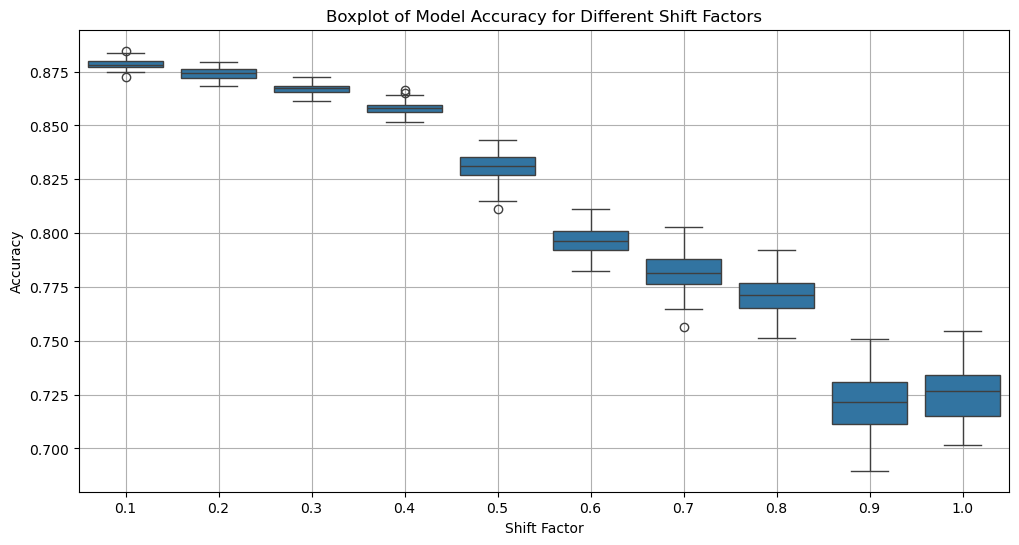

In [3]:
import data_manipulation as dm

# Assuming X_train and y_train are defined
prime_datasets, true_dist = dm.create_low_acc_ds(X_train, y_train, shift_max, X_test, y_test, args, True)

In [ ]:
# import privacy_analysis as pa
# import data_manipulation as dm

# power_all = []
# acc_all = []
# true_dist = dm.get_distribution(X_train, y_train)
# for eps_test in [0.1, 1, 5, 10]:

#     power_one = []
#     acc_one = []
#     for i in range(20):
#         D_hat = pa.create_D_hat(X_train, y_train, eps_test, true_dist)
#         y_hat = y_train

#         power = pa.privacy_eval(X_train, y_train, eps_test, true_dist, X_test, y_test)
#         power_one.append(power)
        
#         M_hat = utils.train_model(D_hat, y_hat, args)
#         M_hat_acc = M_hat.score(X_test, y_test)
#         acc_one.append(M_hat_acc)
        
#     power_all.append(np.mean(power_one))
#     acc_all.append(np.mean(acc_one))

In [4]:
import privacy_analysis as pa
eps = args.epsilon

D_hat = pa.create_D_hat(X_train, y_train, eps, true_dist)
y_hat = y_train
privacy_score = pa.privacy_eval(X_train, y_train, eps, true_dist, X_test, y_test)
print('power : ' + str(privacy_score)) 

(627, 15)
(627, 15)
(627, 15)
(627, 15)
(627, 15)
power : 0.01789137380191693


In [5]:
t_acc_arr, t_exps_ML, t_dists_thresh= disCal_Mhat_Mprime(prime_datasets)

working on the researcher dataset
Obtaining true E and C, and save them for testing later
shift percent: 0.0, acc: 0.8087344596748486
shift percent: 0.1, acc: 0.7950270959515461
shift percent: 0.2, acc: 0.7886515779407077
shift percent: 0.3, acc: 0.7851450430347465
shift percent: 0.4, acc: 0.7446605036659228
shift percent: 0.5, acc: 0.66942939113803


In [6]:
acc, exps_ML, dists_thresh = disCal_Mref_MrefPrime()

working on the reference dataset


In [7]:
# acc_regression(acc)

In [8]:
# Define the number of runs
num_runs = 20

for method in ["lr", "svm"]:
    print(method)
    verif_acc_arr = []
    for spec_label in spec_labels:
        # Initialize lists to store values from each run
        verif_acc = []

        # Loop to simulate multiple runs
        for _ in range(num_runs):
            # Simulating the training and testing process
            # In your case, replace these with your actual training and testing functions

            exp_X_b, exp_y_b, MLVerifier_bin = ML_Verifier_training(exps_ML, method, spec_label, train_frac)
            ML_bin_pred, ML_bin_true = ML_Verifier_testing(t_exps_ML, MLVerifier_bin, spec_label, test_frac)


            temp = verif_acc_run(ML_bin_pred, ML_bin_true)
            verif_acc.append(temp)
        
        verif_acc_arr.append(np.mean(verif_acc))
    print(verif_acc_arr)
print(len(ML_bin_pred))
        # Calculate the average across all runs
#         average_verif_acc = np.mean(verif_acc)        
        
#         plt.boxplot(verif_acc)
#         plt.title('Box Plot of Numpy Array Values')
#         plt.ylabel('Values')
#         plt.show()
        
#         print("mean: " + str(np.mean(verif_acc)))
#         print("median: " + str(np.median(verif_acc)))


        
#         if method == 'lr':
#             print(MLVerifier_bin.coef_)
    

lr
[0, 1]
0.716516129032258
[0, 2]
0.9990645161290324
[0, 3]
1.0
[0, 4]
0.988225806451613
[0, 5]
0.9814516129032256
rf
[0, 1]
0.9103548387096773
[0, 2]
0.9995967741935484
[0, 3]
1.0
[0, 4]
0.6154838709677419
[0, 5]
0.5170645161290323
dt
[0, 1]
0.687774193548387
[0, 2]
0.7936935483870966
[0, 3]
1.0
[0, 4]
0.9327741935483871
[0, 5]
0.8021290322580645


In [ ]:
print(exp_X_b.shape)

{(0, 1.0): 0.06565656565656566, (0, 2.0): 0.29292929292929293, (0, 3.0): 0.12121212121212122, (0, 4.0): 0.13131313131313133, (0, 5.0): 0.15656565656565657}


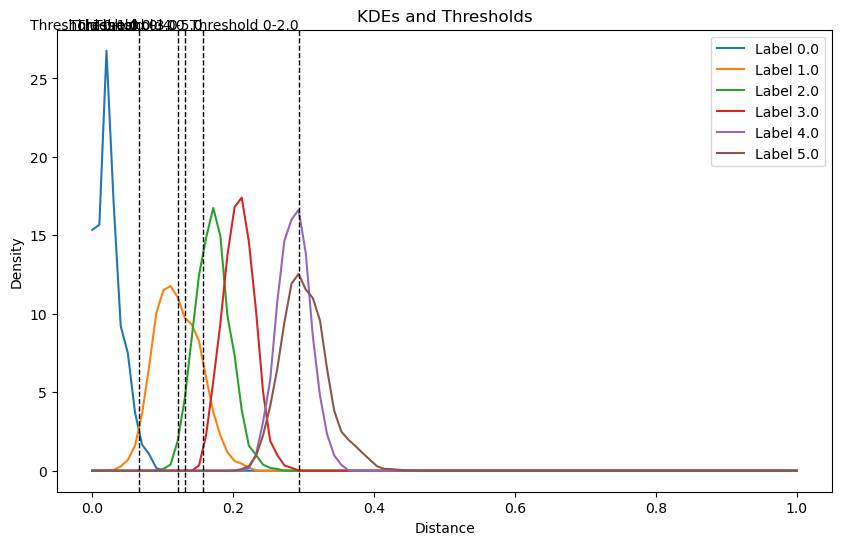

In [10]:
import threshold_verifier as threshv
ThreshVerifier = threshv.Thresh_Verifier_training(dists_thresh)
# ThreshVerifier = Thresh_Verifier_training(dists_thresh)

In [11]:
ThreshVerifier

array([0.06565657, 0.29292929, 0.12121212, 0.13131313, 0.15656566])

In [12]:
# print("V_T mult")
# Thresh_mult_pred, Thresh_mult_true = Thresh_Verifier_testing(t_dists_thresh, ThreshVerifier, [0, 1, 2, 3, 4, 5], mmScaler)
# draw_cm(Thresh_mult_pred, Thresh_mult_true, 'thresh_mult', None)

V_T bin


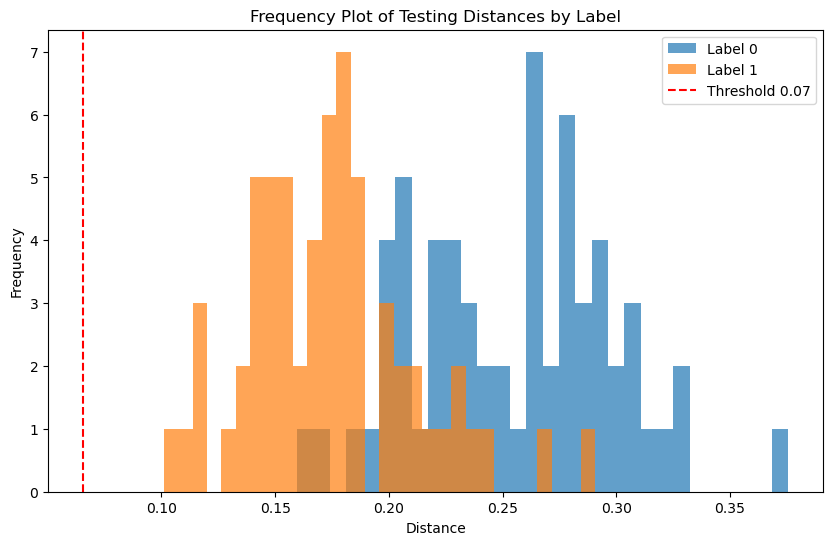

accuracy: 0.5
[[ 0 62]
 [ 0 62]]


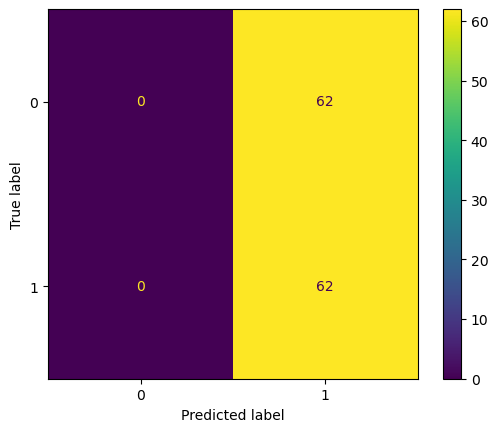

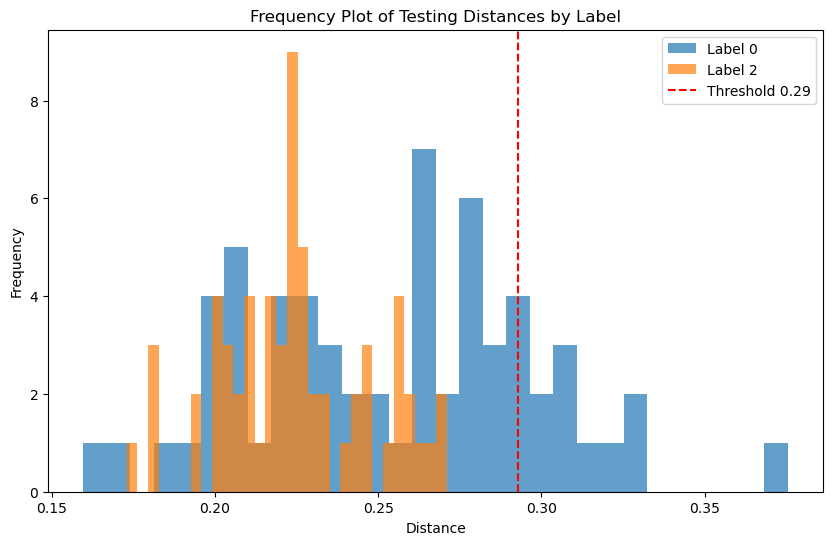

accuracy: 0.3951612903225806
[[49 13]
 [62  0]]


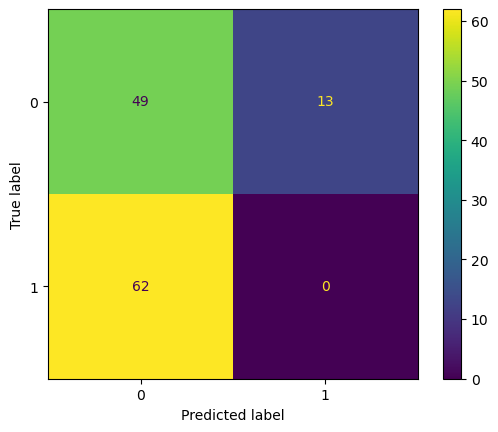

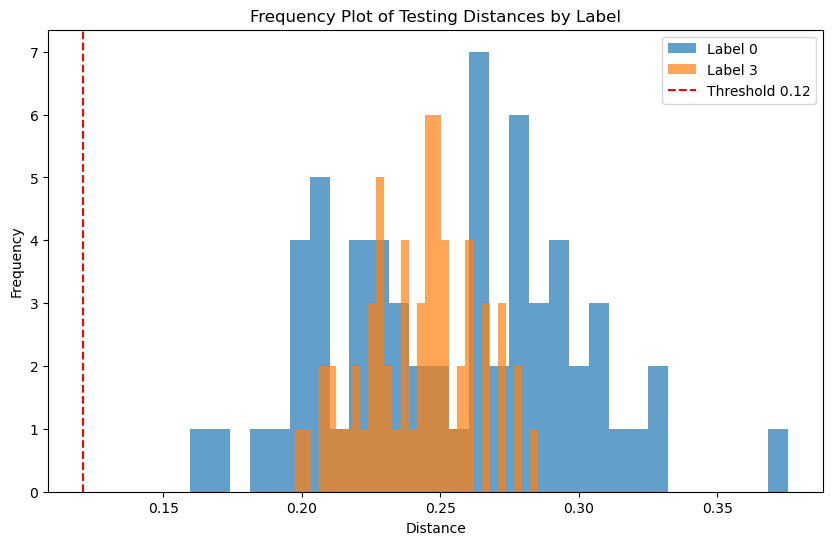

accuracy: 0.5
[[ 0 62]
 [ 0 62]]


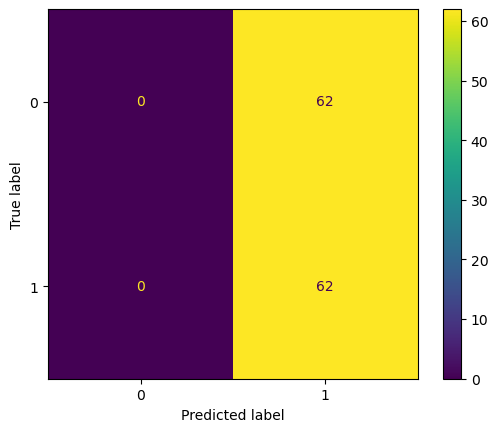

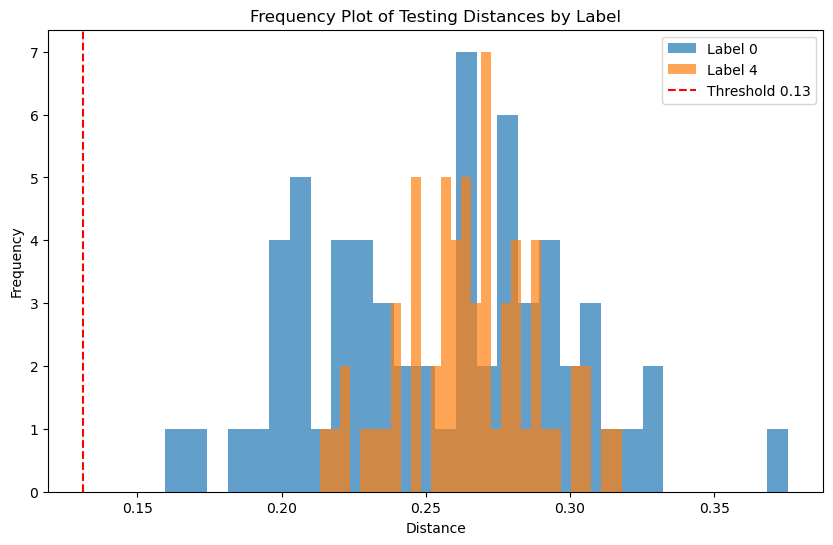

accuracy: 0.5
[[ 0 62]
 [ 0 62]]


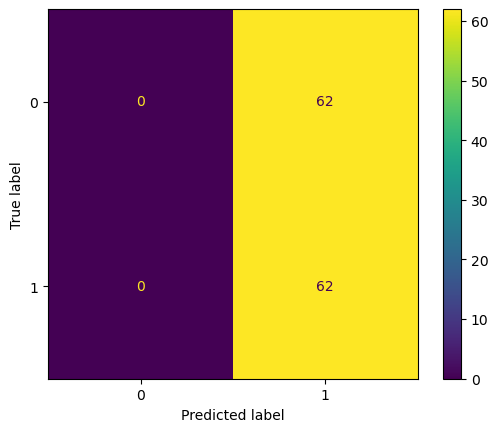

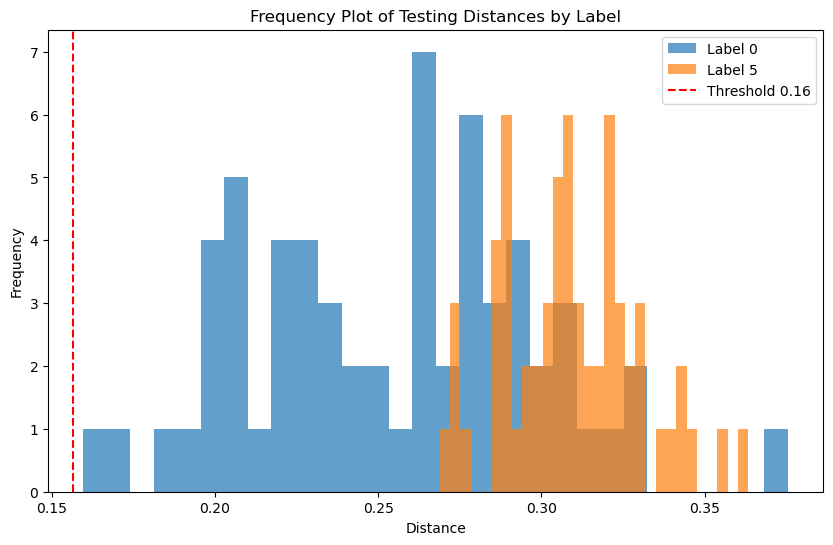

accuracy: 0.5
[[ 0 62]
 [ 0 62]]


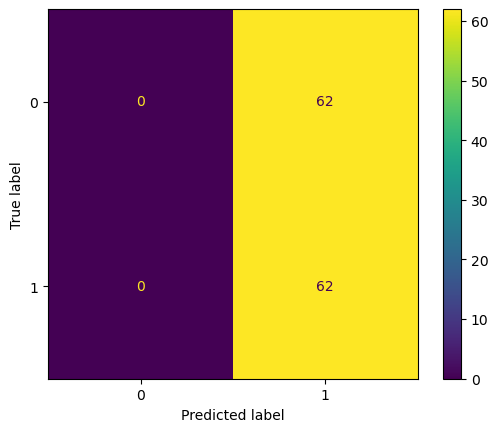

In [13]:
print("V_Th")
Vth_acc = []

for spec_label in spec_labels:
#     Thresh_bin_pred, Thresh_bin_true = threshv.Thresh_Verifier_testing(t_dists_thresh, ThreshVerifier, spec_label, test_frac)
    Thresh_bin_pred, Thresh_bin_true = Thresh_Verifier_testing(t_dists_thresh, ThreshVerifier, spec_label, test_frac)

    acc = draw_cm(Thresh_bin_pred, Thresh_bin_true, 'thresh_bin', None)
    Vth_acc.append(acc)
Vth_acc

In [14]:
# #repeat testing
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# prime_datasets, true_dist = dm.create_low_acc_ds(X_train, y_train, shift_max, X_test, y_test, args, False)
# D_hat = pa.create_D_hat(X_train, y_train, eps, true_dist)
# y_hat = y_train
# privacy_score = pa.privacy_eval(X_train, y_train, eps, true_dist, X_test, y_test)
# print('power: ' + str(privacy_score))

shifted datasets(D prime) created
(627, 15)
(627, 15)
(627, 15)
(627, 15)
(627, 15)


In [15]:
# t_acc_arr, t_exps_ML, t_dists_thresh= disCal_Mhat_Mprime(prime_datasets)

working on the researcher dataset
Obtaining true E and C, and save them for testing later
shift percent: 0.0, acc: 0.7985336308575072
shift percent: 0.1, acc: 0.7975773031558814
shift percent: 0.2, acc: 0.7947083200510041
shift percent: 0.3, acc: 0.7908830092445012
shift percent: 0.4, acc: 0.7510360216767612
shift percent: 0.5, acc: 0.6844118584635002


In [16]:
# # Define the number of runs
# num_runs = 20

# for method in ["lr", "svm"]:
#     print(method)
#     for spec_label in spec_labels:
#         print(spec_label)
#         # Initialize lists to store values from each run
#         verif_acc = []

#         # Loop to simulate multiple runs
#         for _ in range(num_runs):
#             # Simulating the training and testing process
#             # In your case, replace these with your actual training and testing functions

#             exp_X_b, exp_y_b, MLVerifier_bin = ML_Verifier_training(exps_ML, method, spec_label, train_frac)
#             ML_bin_pred, ML_bin_true = ML_Verifier_testing(t_exps_ML, MLVerifier_bin, spec_label)


#             temp = verif_acc_run(ML_bin_pred, ML_bin_true)
#             verif_acc.append(temp)
        
#         # Calculate the average across all runs
# #         average_verif_acc = np.mean(verif_acc)        
        
# #         plt.boxplot(verif_acc)
# #         plt.title('Box Plot of Numpy Array Values')
# #         plt.ylabel('Values')
# #         plt.show()
        
#         print("mean: " + str(np.mean(verif_acc)))
#         print("median: " + str(np.median(verif_acc)))
#         print("training size: " + str(exp_X_b.shape))
#         print("testing size: " + str(ML_bin_true.shape))


        
# #         if method == 'lr':
# #             print(MLVerifier_bin.coef_)
    

lr
[0, 1]
0.9972903225806451
[0, 2]
1.0
[0, 3]
1.0
[0, 4]
0.9861290322580645
[0, 5]
0.9767741935483871
rf
[0, 1]
0.9744354838709677
[0, 2]
0.9991774193548387
[0, 3]
1.0
[0, 4]
0.5465483870967741
[0, 5]
0.5021451612903226
dt
[0, 1]
0.6633225806451614
[0, 2]
0.847532258064516
[0, 3]
1.0
[0, 4]
0.5135967741935483
[0, 5]
0.5265161290322581


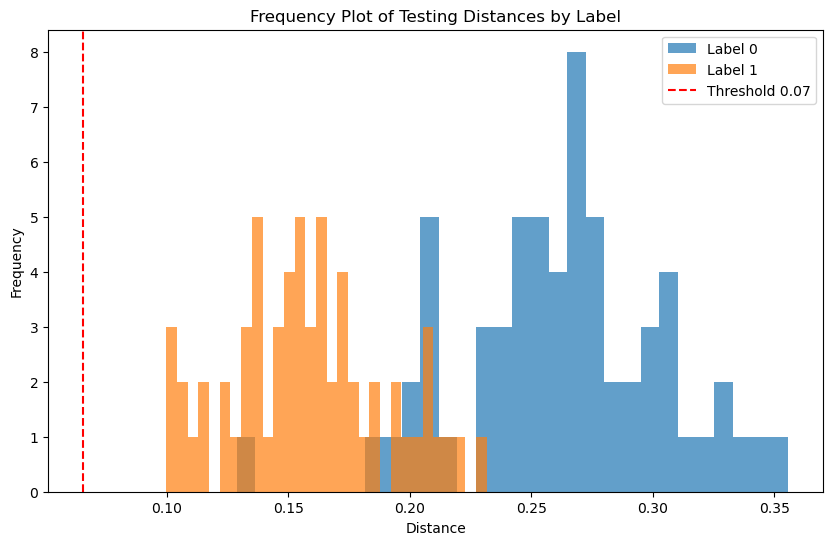

accuracy: 0.5
[[ 0 62]
 [ 0 62]]


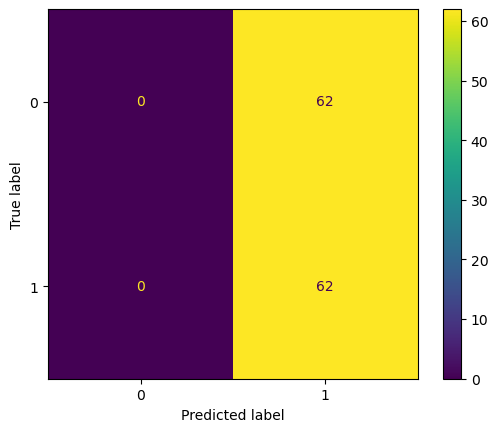

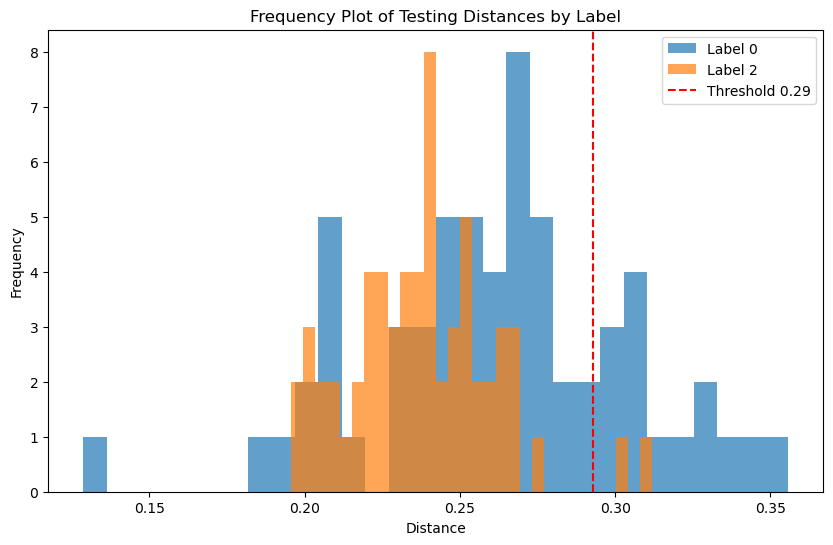

accuracy: 0.3951612903225806
[[47 15]
 [60  2]]


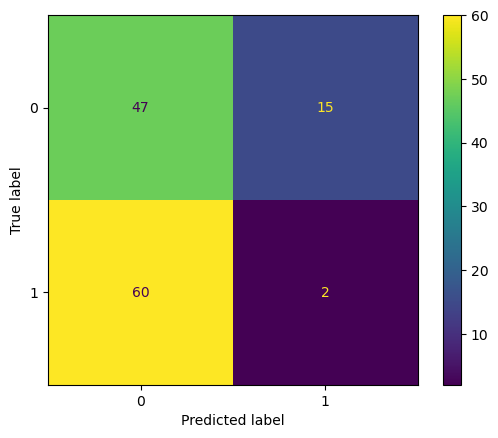

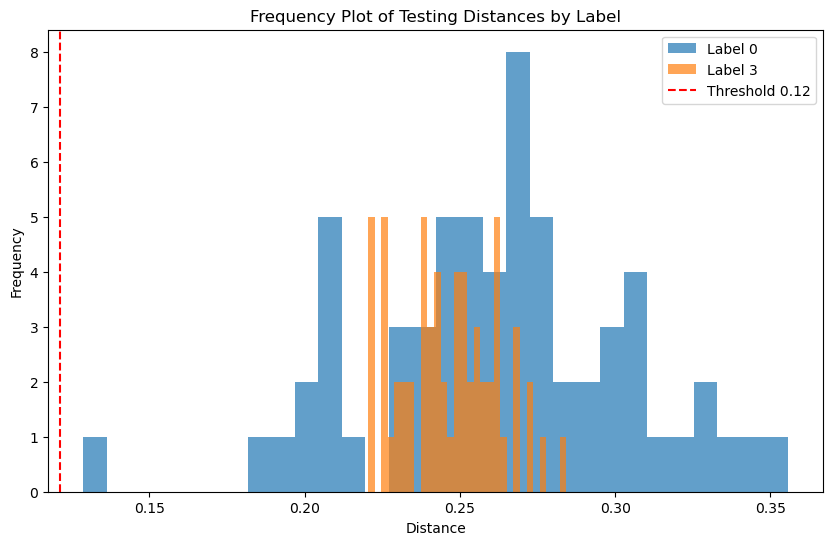

accuracy: 0.5
[[ 0 62]
 [ 0 62]]


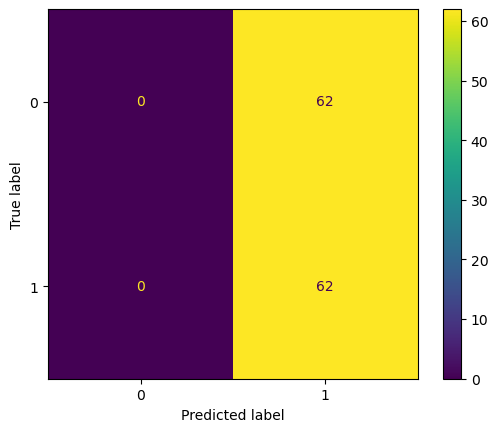

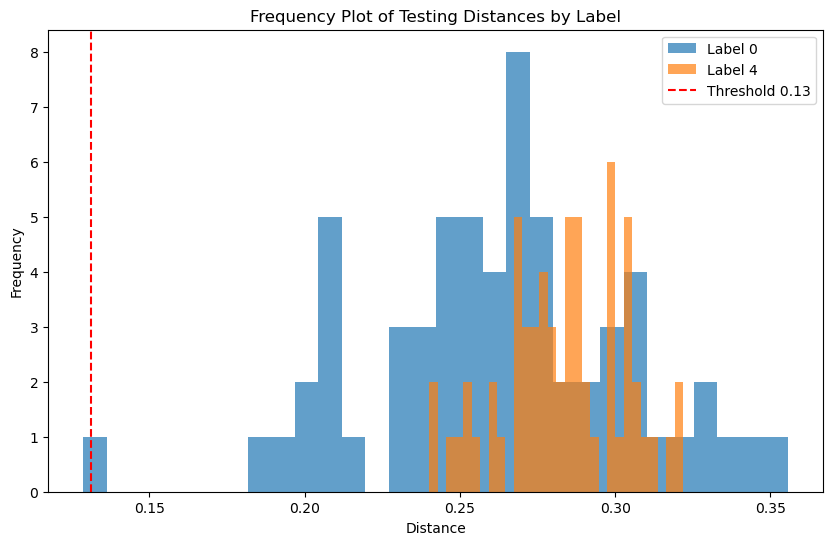

accuracy: 0.5080645161290323
[[ 1 61]
 [ 0 62]]


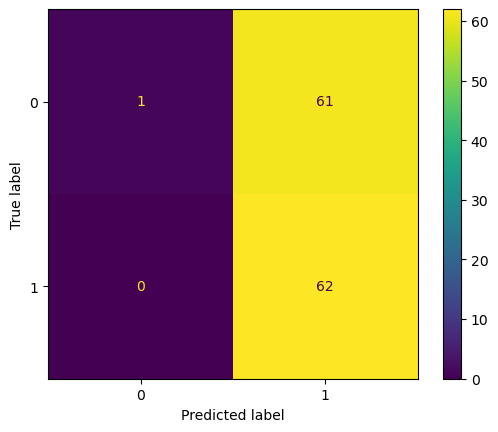

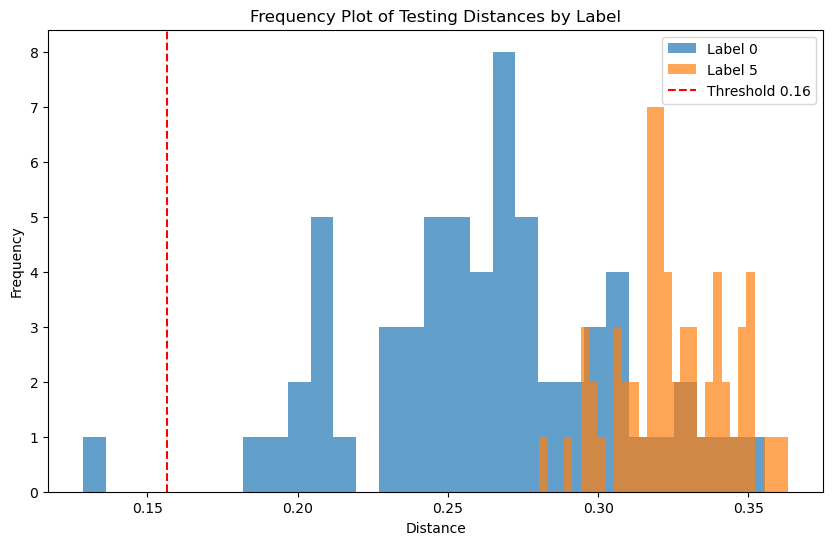

accuracy: 0.5080645161290323
[[ 1 61]
 [ 0 62]]


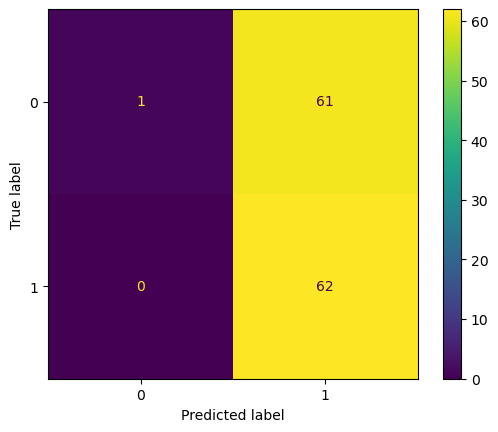

In [17]:
# for spec_label in spec_labels:
#     Thresh_bin_pred, Thresh_bin_true = threshv.Thresh_Verifier_testing(t_dists_thresh, ThreshVerifier, spec_label)
#     draw_cm(Thresh_bin_pred, Thresh_bin_true, 'thresh_bin', None)